In [62]:
import numpy as np
from datasets import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
from transformers import SamProcessor
from torch.utils.data import DataLoader
from patchify import patchify  #Only to handle large images
import os
import random

# https://pytorch.org/docs/stable/index.html
import torch

# https://huggingface.co/docs/transformers/v4.39.3/en/index
from transformers import SamModel, SamProcessor

# pre-defined loader functions
import fishLoader as fish

# pre-defined pre-proc functions
import pre_proc_func as ppf

In [63]:
def process_tiff_images(folder_path, exposure_factor=30):
    # Create a Path object for the folder
    folder = pathlib.Path(folder_path)
    
    # List to store the processed image arrays
    processed_images = []

    # Collect all TIFF files, considering both '.tif' and '.tiff' extensions
    file_names = os.listdir(folder_path)
    tiff_files = [file for file in file_names if file.endswith(".tif") or file.endswith(".tiff")]
    tiff_files.sort()

    # Iterate over each sorted TIFF file
    for file_path in tiff_files:
        with Image.open(folder_path + "/" + file_path) as img:
            # Convert the image to a NumPy array
            image_array = np.array(img)

            # Adjust exposure and clip values
            exposed_image_array = np.clip(image_array * exposure_factor, 0, 65535)

            # Append the processed image array to the list
            processed_images.append(exposed_image_array)
    
    return processed_images

def grayscale_to_rgb(grayscale_imgs):
    # Initialize an empty array to hold the RGB images
    # The new shape will have an extra dimension for the channels at the end
    rgb_imgs = np.zeros((grayscale_imgs.shape[0], grayscale_imgs.shape[1], grayscale_imgs.shape[2], 3), dtype=np.uint8)
    
    for i in range(grayscale_imgs.shape[0]):
        # Duplicate the grayscale image data across three channels
        rgb_imgs[i] = np.stack((grayscale_imgs[i],) * 3, axis=-1)

    return rgb_imgs


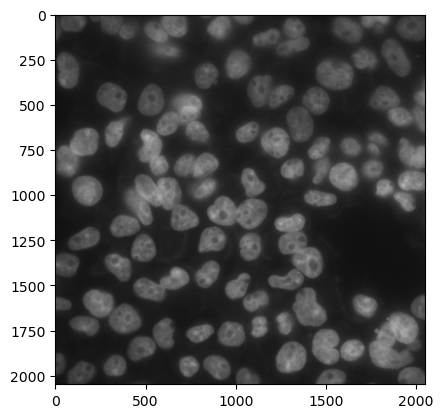

In [64]:
images = process_tiff_images('201-250_Hong', exposure_factor=30)
plt.figure()
plt.imshow(images[3], cmap='gray', vmin=0, vmax=65535)
plt.show()

In [65]:
filtered_masks, valid_indices = fish.get_masks_from_mat('201-250_Hong/201-250_finished.mat', 'Tracked_201250')
print(valid_indices)
filtered_images = np.array([images[i] for i in valid_indices]) # filters out the images that don't have masks


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [66]:
filtered_images.shape

(50, 2048, 2048)

In [67]:
filtered_masks.shape

(50, 2048, 2048)

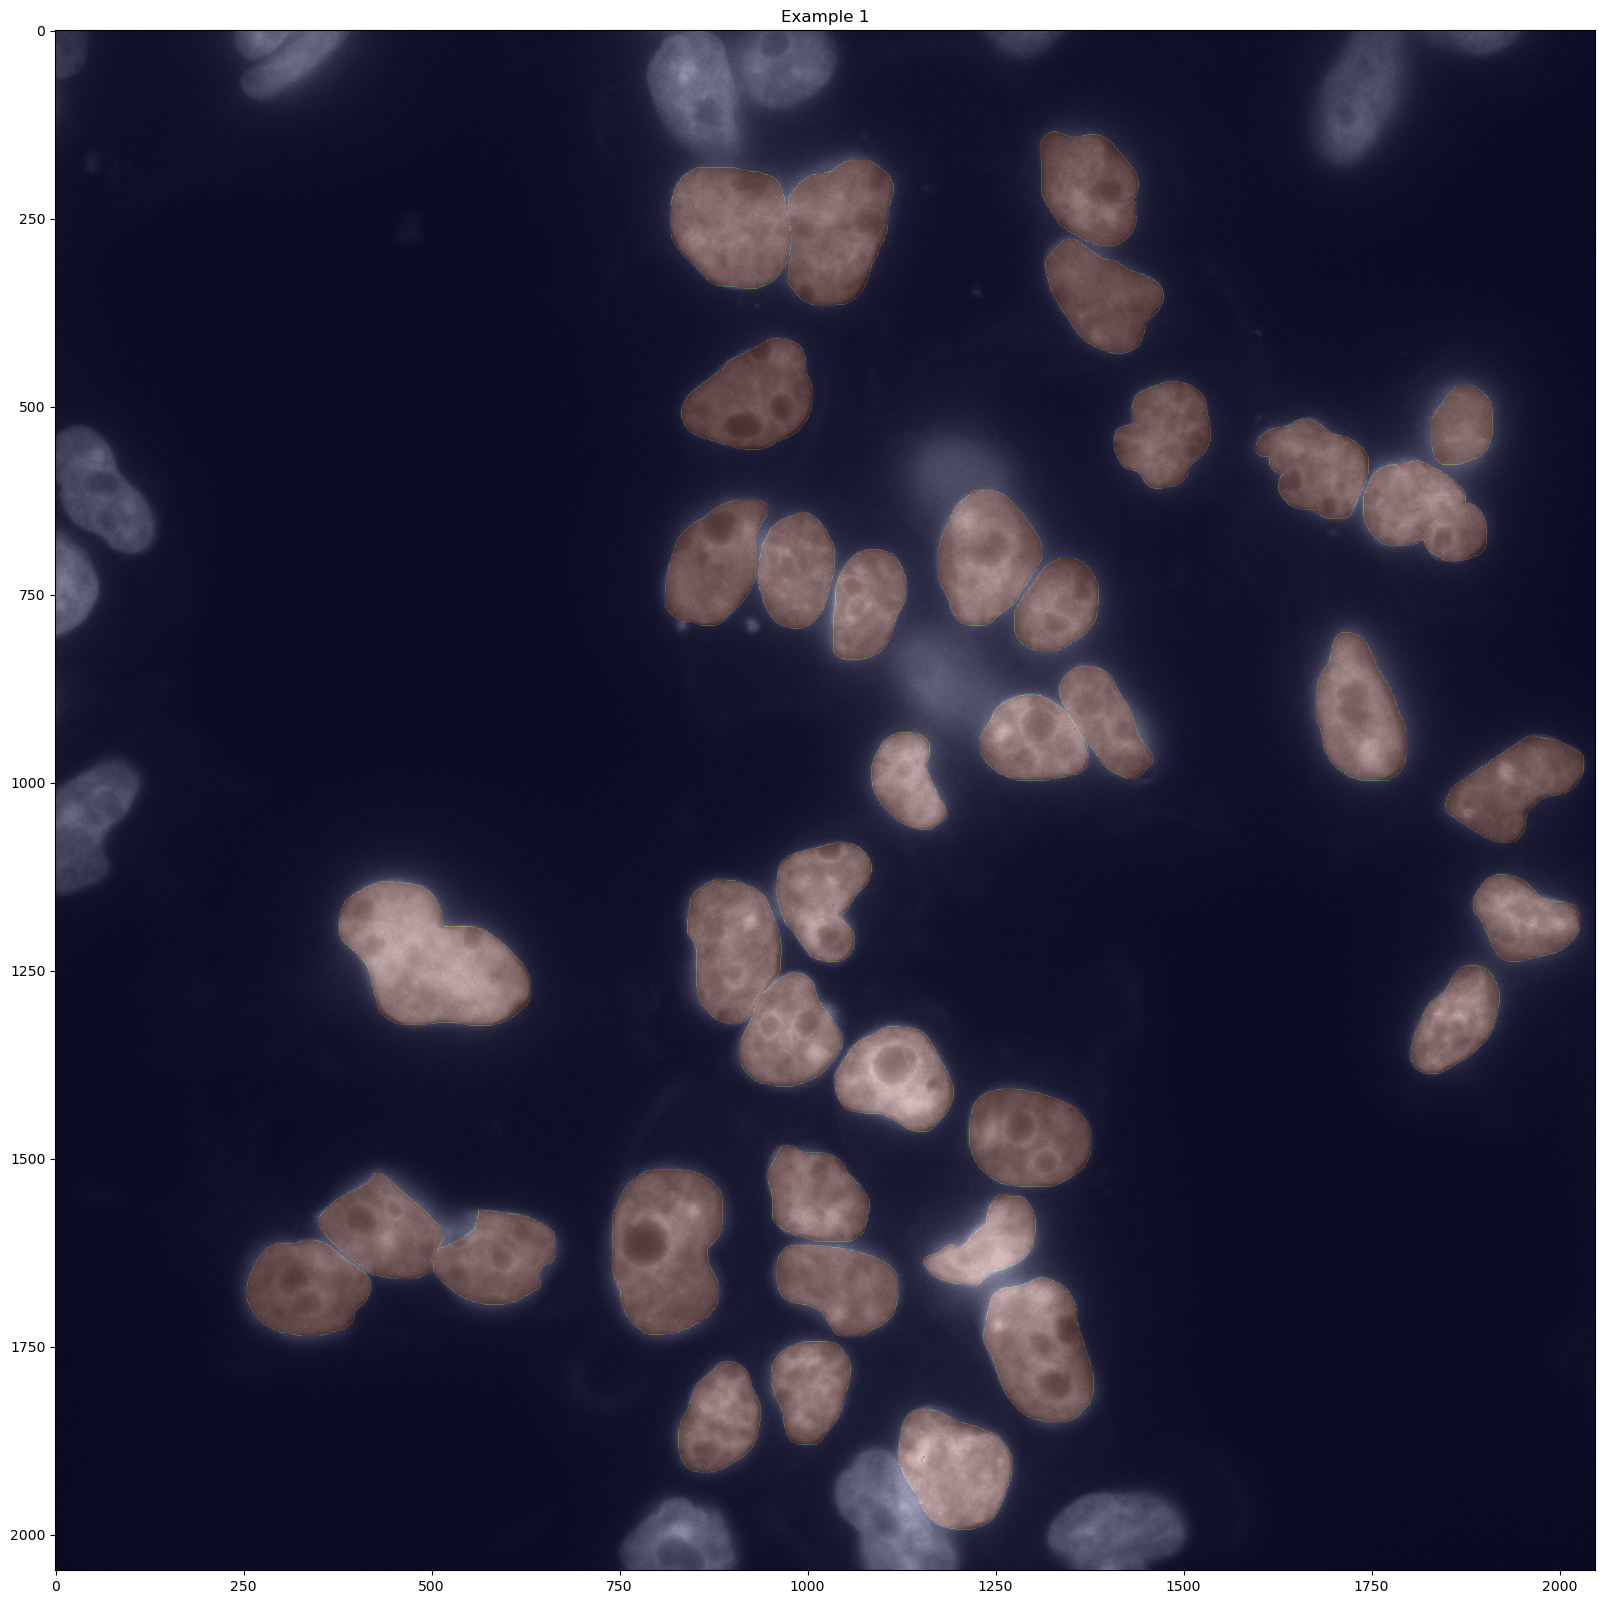

In [68]:
fish.plot_mask_on_image(filtered_images[1], filtered_masks[1], 'Example 1')

In [69]:
def rgb_to_grayscale(images):
    # Initialize an empty array to hold the grayscale images
    grayscale_imgs = np.zeros((images.shape[0], images.shape[1], images.shape[2]), dtype=np.uint8)
    
    for i in range(images.shape[0]):
        # Convert each RGB image to a PIL Image, then convert to grayscale
        pil_img = Image.fromarray(images[i].astype('uint8'), 'RGB')
        gray_img = pil_img.convert('L')
        # Convert back to numpy array and store in the grayscale_imgs array
        grayscale_imgs[i] = np.array(gray_img)

    return grayscale_imgs

# Convert your filtered images
grayscale_images = filtered_images
grayscale_images.shape

(50, 2048, 2048)

In [70]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 255

all_img_patches = []
for img in range(grayscale_images.shape[0]):
    large_image = grayscale_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(filtered_masks.shape[0]):
    large_mask = filtered_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

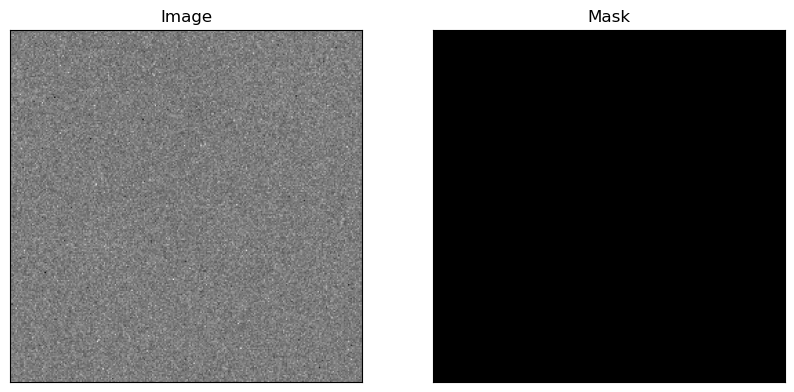

In [71]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = images[img_num]
example_mask = masks[img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [72]:
images.shape

(3200, 256, 256)

In [73]:
masks.shape

(3200, 256, 256)

In [74]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
images_ready = images[valid_indices]
masks_ready = masks[valid_indices]
print("Image shape:", images_ready.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", masks_ready.shape)

Image shape: (2851, 256, 256)
Mask shape: (2851, 256, 256)


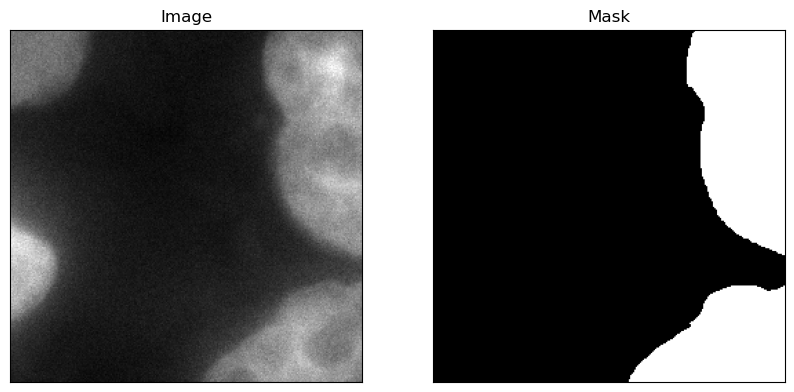

In [75]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = images_ready[img_num]
example_mask = masks_ready[img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [76]:
images_ready.shape

(2851, 256, 256)

In [77]:
rgb_images_ready = grayscale_to_rgb(images_ready)

In [78]:
rgb_images_ready.shape

(2851, 256, 256, 3)

In [79]:
rgb_images_ready[0][0][0]

array([34, 34, 34], dtype=uint8)

In [80]:
# Convert the NumPy arrays to Pillow images, storing them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img.astype(np.uint8)) for img in rgb_images_ready],
    "label": [Image.fromarray(mask) for mask in masks_ready],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2851
})

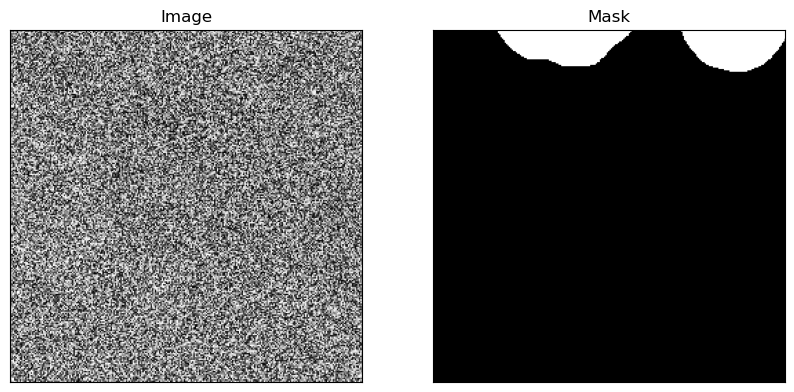

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image))  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# "facebook/sam-vit-huge" is equivalent to "ViT-H SAM model"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [ ]:
print(len(dataset))
print(dataset[0])
print(dataset.dataset_size)

2851
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x350F842D0>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256 at 0x350F84510>}
None


In [ ]:
train_dataset = ppf.SAMDataset(dataset=dataset, processor=processor)

In [ ]:
train_dataset

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

[26, 33, 256, 204]
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

[0, 0, 256, 256]
[0, 0, 256, 256]
pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [ ]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/1426 [00:00<?, ?it/s]

[5, 108, 256, 256]
[64, 102, 228, 256]


  0%|          | 1/1426 [00:05<2:12:11,  5.57s/it]

[0, 0, 256, 256]
[0, 0, 255, 256]


  0%|          | 2/1426 [00:11<2:11:08,  5.53s/it]

[0, 0, 256, 89]
[0, 0, 256, 186]


  0%|          | 3/1426 [00:16<2:10:22,  5.50s/it]

[0, 0, 247, 256]
[0, 0, 256, 256]


  0%|          | 3/1426 [00:17<2:21:21,  5.96s/it]


KeyboardInterrupt: 